## Assignment 1
Based off the provide jumpstart script by Professor Miller.

In [2]:
%pip install polars

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

import yfinance as yf  # used earlier to obtain the price series
import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

In [5]:
symbol = 'T'
start_date = '2000-01-01'
end_date = '2025-05-27'

symbol = 'T'
ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date, period = '1mo')
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_csv("T_historical_data.csv")

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [6]:
att = pl.read_csv("T_historical_data.csv", try_parse_dates=True)

# check the original schema
print(att.schema)

# drop useless columns Dividends and StockSplits
att = att.drop(['Dividends', 'Stock Splits'])

# create lag price features
att = att.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
att = att.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
att = att.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
att = att.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
att = att.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
att = att.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
att = att.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
att = att.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
att = att.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
att = att.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
att = att.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
att = att.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
att = att.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
att = att.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
att = att.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
att = att.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
att = att.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
att = att.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
att = att.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
att = att.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),    
    pl.col('Low').round(3),
    pl.col('Close').round(3),      
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),  
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),  
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),  
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),  
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),  
    pl.col('OMCLag3').round(3), 
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3), 
    pl.col('CloseEMA8').round(3))
    
# define binary target/response 1 = market price up since previous day, 0 = even or down 
att = att.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

print(att.schema)

# save to external comma-delimited text file for checking calculations in Excel
att.write_csv("att-with-computed-features.csv")

Schema([('Date', Datetime(time_unit='us', time_zone='UTC')), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Int64), ('Dividends', Float64), ('Stock Splits', Float64)])
Schema([('Date', Datetime(time_unit='us', time_zone='UTC')), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Float64), ('CloseLag1', Float64), ('CloseLag2', Float64), ('CloseLag3', Float64), ('HML', Float64), ('HMLLag1', Float64), ('HMLLag2', Float64), ('HMLLag3', Float64), ('OMC', Float64), ('OMCLag1', Float64), ('OMCLag2', Float64), ('OMCLag3', Float64), ('VolumeLag1', Float64), ('VolumeLag2', Float64), ('VolumeLag3', Float64), ('CloseEMA2', Float64), ('CloseEMA4', Float64), ('CloseEMA8', Float64), ('LogReturn', Float64), ('Target', Int32)])


In [7]:
# Drop the rows with null values such as the initial lag rows
att = att.drop_nulls()

# Descriptive statistics
attStatistics = att.drop('Date').describe()

print(attStatistics.columns)

attStatisticsToPrint = attStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(attStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(attStatisticsToPrint)



['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema([('column', String), ('column_0', String), ('column_2', String), ('column_3', String), ('column_4', String), ('column_6', String), ('column_8', String)])
┌────────────┬──────────┬────────────────────────┬──────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2               ┆ column_3             ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════╪══════════╪════════════════════════╪══════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                   ┆ std                  ┆ min                  ┆ 50%                   ┆ max       

In [8]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = att.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
6.112,6.018,6.392,0.111,0.578,0.323,0.009,0.383,0.213,1.203516e7,9.497846e6,7.668476e6,6.125,6.145,6.159
5.993,6.112,6.018,0.257,0.111,0.578,0.111,0.009,0.383,9.471366e6,1.203516e7,9.497846e6,6.055,6.086,6.106
6.045,5.993,6.112,0.188,0.257,0.111,0.06,0.111,0.009,7.792534e6,9.471366e6,1.203516e7,6.05,6.071,6.089
6.13,6.045,5.993,0.103,0.188,0.257,-0.0,0.06,0.111,9.425159e6,7.792534e6,9.471366e6,6.091,6.091,6.099
6.045,6.13,6.045,0.154,0.103,0.188,0.077,-0.0,0.06,8.569987e6,9.425159e6,7.792534e6,6.067,6.076,6.087


In [9]:
# Define and examine the target for regression model development
print(att['LogReturn'].describe())

y = np.array(att['LogReturn'])


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 6384.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000234  │
│ std        ┆ 0.016171  │
│ min        ┆ -0.135376 │
│ 25%        ┆ -0.007079 │
│ 50%        ┆ 0.000534  │
│ 75%        ┆ 0.007749  │
│ max        ┆ 0.150832  │
└────────────┴───────────┘


In [10]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


In [11]:
# Define and examine the target for classification model development
print(att['Target'].value_counts())

y = np.array(att['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 3104  │
│ 1      ┆ 3280  │
└────────┴───────┘


In [12]:
# Polars DataFrame for storing results from all possible subsets 
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64} 
resultsDataFrame = pl.DataFrame(schema = resultsSchema) 

def getAIC(X, y): 
    model = LogisticRegression()
    model.fit(X, y)
    # Calculate log-likelihood
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    # Calculate the number of parameters
    k = X.shape[1] + 1    
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik     
    # print(f"AIC: {aic}") # print for initial testing
    return aic

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
for c in powerset(range(X.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)          
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": "0 1 2 3 4 5 6 7 8 9 10 11 12 13 14",
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)          
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])


In [13]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬───────────────┬─────────────┐
│ trialNumber ┆ features      ┆ aic         │
│ ---         ┆ ---           ┆ ---         │
│ i64         ┆ str           ┆ f64         │
╞═════════════╪═══════════════╪═════════════╡
│ 2573        ┆ 0 3 7 11 14   ┆ 8835.163629 │
│ 771         ┆ 0 3 11 14     ┆ 8835.911349 │
│ 6319        ┆ 0 3 5 7 11 14 ┆ 8836.012643 │
│ 2572        ┆ 0 3 7 11 13   ┆ 8836.108487 │
│ 6425        ┆ 0 3 7 8 11 14 ┆ 8836.31056  │
│ 6316        ┆ 0 3 5 7 10 14 ┆ 8836.341792 │
│ 4444        ┆ 3 7 11 12 14  ┆ 8836.494711 │
│ 3783        ┆ 2 3 7 11 14   ┆ 8836.666523 │
│ 2570        ┆ 0 3 7 10 14   ┆ 8836.706542 │
│ 5785        ┆ 0 2 3 7 11 14 ┆ 8836.760449 │
└─────────────┴───────────────┴─────────────┘


### Selected Feature Subset
Reviewing the ten lowest *AIC* models, we selected five features for subsequent model development:
- **HMLLag1** Lag-one high minus low daily prices
- **HMLLag3** Lag-three high minus low daily prices
- **OMCLag2** Lag-two open minus closing daily prices
- **VolumeLag3** Lag-three daily volume
- **CloseEMA8** Exponential moving average across eight days

shape: (7, 7)
┌───────────┬───────────┬───────────┬───────────┬───────────┬────────────┬───────────┐
│ LogReturn ┆ CloseLag1 ┆ HMLLag1   ┆ HMLLag3   ┆ OMCLag2   ┆ VolumeLag3 ┆ CloseEMA8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64        ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════════╪═══════════╡
│ 1.0       ┆ -0.004836 ┆ -0.00079  ┆ 0.009045  ┆ 0.037389  ┆ 0.031179   ┆ -0.002579 │
│ -0.004836 ┆ 1.0       ┆ 0.49294   ┆ 0.491112  ┆ -0.051559 ┆ 0.426213   ┆ 0.998854  │
│ -0.00079  ┆ 0.49294   ┆ 1.0       ┆ 0.595158  ┆ -0.019713 ┆ 0.342079   ┆ 0.500492  │
│ 0.009045  ┆ 0.491112  ┆ 0.595158  ┆ 1.0       ┆ -0.081949 ┆ 0.53019    ┆ 0.497017  │
│ 0.037389  ┆ -0.051559 ┆ -0.019713 ┆ -0.081949 ┆ 1.0       ┆ -0.007918  ┆ -0.035213 │
│ 0.031179  ┆ 0.426213  ┆ 0.342079  ┆ 0.53019   ┆ -0.007918 ┆ 1.0        ┆ 0.431768  │
│ -0.002579 ┆ 0.998854  ┆ 0.5

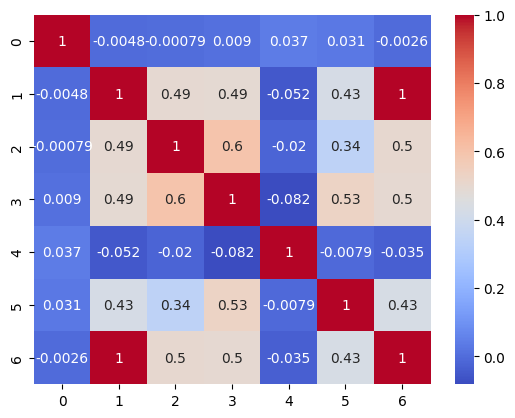

In [16]:
# examine relationships among five selected features, along with LogReturn and CloseLag1
XStudy = att.select('LogReturn','CloseLag1','HMLLag1','HMLLag3','OMCLag2','VolumeLag3','CloseEMA8')

# prepare correlation heat map using seaborn
corrMatrix = XStudy.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True)
plt.show()

In [17]:
# select subset of five columns as features
X = att.select('HMLLag1','HMLLag3','OMCLag2','VolumeLag3','CloseEMA8')

In [18]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 1054 with indices from  0 to 1053
test_0 has 1064 with indices from  1064 to 2127

train_1 has 2118 with indices from  0 to 2117
test_1 has 1064 with indices from  2128 to 3191

train_2 has 3182 with indices from  0 to 3181
test_2 has 1064 with indices from  3192 to 4255

train_3 has 4246 with indices from  0 to 4245
test_3 has 1064 with indices from  4256 to 5319

train_4 has 5310 with indices from  0 to 5309
test_4 has 1064 with indices from  5320 to 6383


In [19]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

In [20]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")



Mean model.n_estimators = 1000.0


(np.float64(0.4947368421052632), np.float64(0.016490009172527288))

In [21]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.495 +/- 0.016



In [22]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': np.float64(0.08964522558051516), 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 881, 'subsample': np.float64(0.8014120643245294)}
Best score: 0.5058270676691728


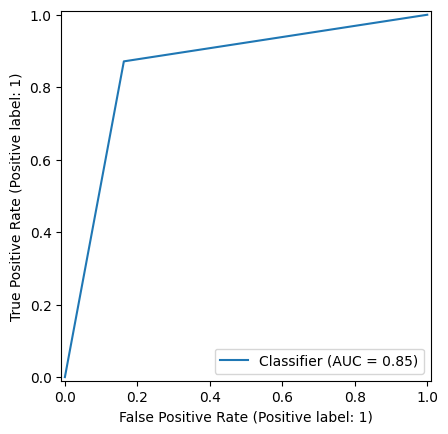

In [23]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 9, subsample = 0.50, learning_rate = 0.09, n_estimators = 273)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)
                    

Confusion Matrix
[[2599  505]
 [ 422 2858]]


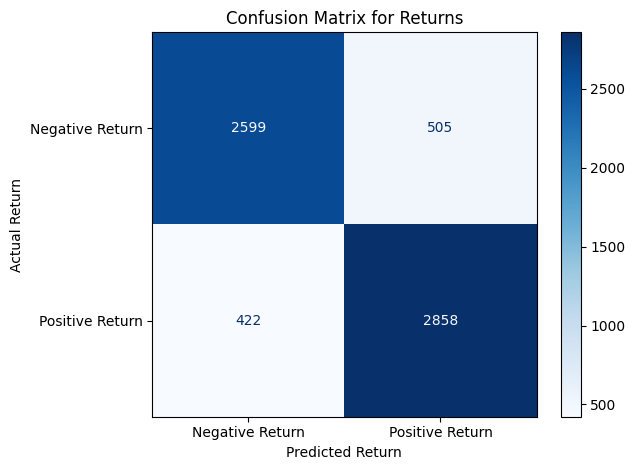

In [24]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()                              

In [25]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3104
           1       0.85      0.87      0.86      3280

   micro avg       0.85      0.85      0.85      6384
   macro avg       0.86      0.85      0.85      6384
weighted avg       0.85      0.85      0.85      6384



## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).